In [87]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t=None, y=None, feeds: Optional[pd.DataFrame] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
    
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
    
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)

    plt.xlabel("Time (hours)")
    plt.ylabel("Concentration")
    plt.title(title)
    
    if feeds is not None:
        ax2 = ax1.twinx()
        ax2.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], \
            align='edge', label='Feed', alpha=0.5, color=None, \
            edgecolor='black', linewidth=1, fill=False)
        ax2.set_ylabel('Feed Rate')

    
    handles1, labels1 = ax1.get_legend_handles_labels()
    if feeds is not None:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax2.legend(handles, labels, loc='upper left')
    else:
        ax1.legend(handles1, labels1, loc='upper left')

    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df: pd.DataFrame, feeds: pd.DataFrame, mu_max, Ks, Yxs, plot: bool = True):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    Sin = 1.43 * 200

    def system_ode(t, y):
        X, S, V = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dVdt = F
        return [dXdt, dSdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, feeds=feeds, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

In [89]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR02'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Get FB and FBI data
df = df[df['Process'] == 'FB']
feeds = feeds[feeds['Induction']==0]

print(f'Dataset shape: {df.shape}')

Dataset shape: (5, 8)


In [81]:
def main(df: pd.DataFrame):
    t_start, t_end = df['RTime'].min(), df['RTime'].max()

    t_train = numpy_to_tensor(df['RTime'].values)
    Biomass_train = numpy_to_tensor(df['Biomass'].values)
    Glucose_train = numpy_to_tensor(df['Glucose'].values)
    V_train = numpy_to_tensor(df['V'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train), 1)

    net = PINN(input_dim=1, output_dim=3, t_start=t_start, t_end=t_end)

    net = train(net, t_train, u_train, df, feeds, num_epochs=2500, verbose=200)

    net_df = get_predictions_df(net, df)    

    sol = simulate(df, feeds, net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), plot=False)

    title = f"mu_max: {net.mu_max.item():4f}, Ks: {net.K_s.item():4f}, Yxs: {net.Y_xs.item():.4f}"
    plot_simulation(sol.t, sol.y, net_df=net_df, train_df=df, full_df=df, title=title)
    
    return net, net_df

  0%|          | 0/2500 [00:00<?, ?it/s]


  0%|          | 10/2500 [00:00<00:50, 48.84it/s]

mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995
X_data_loss = 273.1177
S_data_loss = 0.0851
V_data_loss = 2.2762
X_IC_loss = 36.9451
S_IC_loss = 0.0420
V_IC_loss = 1.9906
error_ode = 9698.9658


  8%|▊         | 207/2500 [00:04<00:41, 55.02it/s]

mu_max: 0.6205, Ks: 0.3885, Yxs: 0.3674
X_data_loss = 157.6145
S_data_loss = 1.0146
V_data_loss = 0.6764
X_IC_loss = 12.0806
S_IC_loss = 0.4405
V_IC_loss = 0.0029
error_ode = 3.2257


 16%|█▌        | 405/2500 [00:08<00:44, 46.93it/s]

mu_max: 0.6185, Ks: 0.3962, Yxs: 0.3494
X_data_loss = 10.4397
S_data_loss = 0.0119
V_data_loss = 0.4828
X_IC_loss = 9.7694
S_IC_loss = 0.0041
V_IC_loss = 0.0010
error_ode = 1.7033


 24%|██▍       | 611/2500 [00:12<00:35, 53.31it/s]

mu_max: 0.6192, Ks: 0.3956, Yxs: 0.3408
X_data_loss = 8.4567
S_data_loss = 0.0131
V_data_loss = 0.3129
X_IC_loss = 8.2166
S_IC_loss = 0.0032
V_IC_loss = 0.0005
error_ode = 1.8892


 32%|███▏      | 807/2500 [00:16<00:33, 50.72it/s]

mu_max: 0.6207, Ks: 0.3934, Yxs: 0.3422
X_data_loss = 5.3380
S_data_loss = 0.0137
V_data_loss = 0.2288
X_IC_loss = 5.0665
S_IC_loss = 0.0042
V_IC_loss = 0.0000
error_ode = 2.2653


 40%|████      | 1008/2500 [00:20<00:30, 49.44it/s]

mu_max: 0.6228, Ks: 0.3897, Yxs: 0.3654
X_data_loss = 2.4193
S_data_loss = 0.0172
V_data_loss = 0.1561
X_IC_loss = 2.1900
S_IC_loss = 0.0079
V_IC_loss = 0.0066
error_ode = 2.8891


 48%|████▊     | 1208/2500 [00:23<00:24, 53.37it/s]

mu_max: 0.6256, Ks: 0.3830, Yxs: 0.4088
X_data_loss = 0.8833
S_data_loss = 0.0228
V_data_loss = 0.1393
X_IC_loss = 0.6133
S_IC_loss = 0.0152
V_IC_loss = 0.0187
error_ode = 3.2669


 56%|█████▋    | 1409/2500 [00:28<00:19, 55.23it/s]

mu_max: 0.6299, Ks: 0.3721, Yxs: 0.4592
X_data_loss = 0.3778
S_data_loss = 0.0280
V_data_loss = 0.1703
X_IC_loss = 0.1653
S_IC_loss = 0.0240
V_IC_loss = 0.0251
error_ode = 3.5039


 64%|██████▍   | 1604/2500 [00:32<00:18, 49.09it/s]

mu_max: 0.6356, Ks: 0.3568, Yxs: 0.5050
X_data_loss = 0.2537
S_data_loss = 0.0303
V_data_loss = 0.2267
X_IC_loss = 0.0652
S_IC_loss = 0.0304
V_IC_loss = 0.0234
error_ode = 3.4076


 72%|███████▏  | 1807/2500 [00:35<00:12, 54.47it/s]

mu_max: 0.6424, Ks: 0.3380, Yxs: 0.5431
X_data_loss = 0.2094
S_data_loss = 0.0300
V_data_loss = 0.2865
X_IC_loss = 0.0424
S_IC_loss = 0.0329
V_IC_loss = 0.0193
error_ode = 3.2860


 80%|████████  | 2008/2500 [00:39<00:09, 52.36it/s]

mu_max: 0.6501, Ks: 0.3166, Yxs: 0.5738
X_data_loss = 0.1983
S_data_loss = 0.0280
V_data_loss = 0.3392
X_IC_loss = 0.0277
S_IC_loss = 0.0325
V_IC_loss = 0.0153
error_ode = 3.1859


 88%|████████▊ | 2209/2500 [00:43<00:05, 51.14it/s]

mu_max: 0.6581, Ks: 0.2933, Yxs: 0.5985
X_data_loss = 0.1833
S_data_loss = 0.0248
V_data_loss = 0.3866
X_IC_loss = 0.0229
S_IC_loss = 0.0300
V_IC_loss = 0.0126
error_ode = 3.1159


 96%|█████████▋| 2411/2500 [00:47<00:01, 55.33it/s]

mu_max: 0.6660, Ks: 0.2689, Yxs: 0.6184
X_data_loss = 0.1743
S_data_loss = 0.0212
V_data_loss = 0.4251
X_IC_loss = 0.0192
S_IC_loss = 0.0263
V_IC_loss = 0.0106
error_ode = 3.0658


100%|██████████| 2500/2500 [00:49<00:00, 51.01it/s]


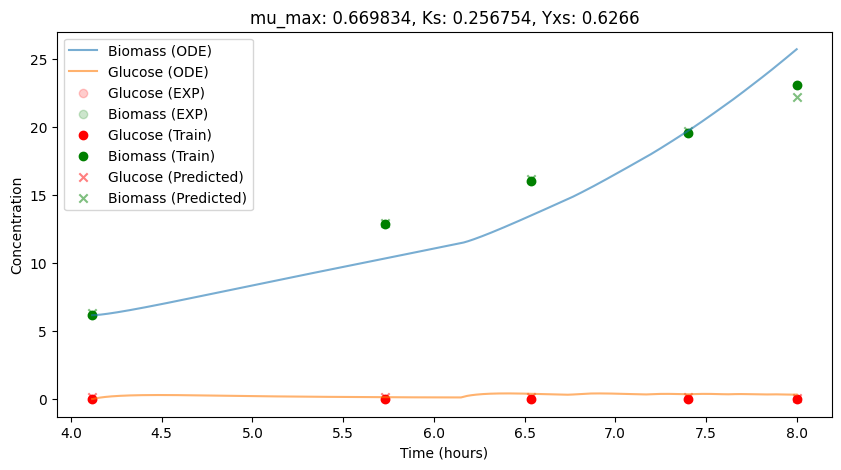

In [90]:
repeat = True
while repeat:
    try:
        net, net_df = main(df)
        repeat = False
    except ValueError:
        pass

In [91]:
net_df

,RTime,Biomass,Glucose,V
0,4.116667,6.312082,0.166905,1.385968
1,5.733333,12.920611,0.149131,1.957966
2,6.533333,16.190815,0.140335,2.241016
3,7.400000,19.733530,0.130807,2.547654
4,8.000000,22.186182,0.124211,2.759942


In [92]:
df

,Process,RTime,Glucose,Biomass,Protein,Temperature,Induction,V
BR02,FB,4.116667,0.011,6.175000,0.0,37,0,1.483981
BR02,FB,5.733333,0.000,12.871429,0.0,37,0,1.559670
BR02,FB,6.533333,0.000,16.071429,0.0,37,0,1.622434
BR02,FB,7.400000,0.010,19.550000,0.0,37,0,1.713444
BR02,FB,8.000000,0.000,23.071429,0.0,37,0,1.779788
